# Построение ML продукта для предсказания визитов клиентов
Описание: [mle_предсказание_количества_визитов](https://incredible-tulip-5c3.notion.site/Machine-learning-engineer-2024-e4c30223002a4eebb33d2cdeb8f81fb1)

**Формулировка задачи:**

Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год.
<br>Требуется на основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 

Доступны 2 выборки: 

- train - выборка для обучения и валидации , 50 тыс. застрахованных с проставленными значениями target.
- holdout - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения target скрыты.

Для оценки качества модели будет применяться метрика `MSE`.

**Описание данных:**

- Insured_PIN - уникальный ид застрахованного лица
- Insured_Network - Идентификатор сети клиник доступной для застрахованного. Network - 1 - клиники с наивысшим уровнем сервиса, Network - 8 - клиники с самым базовым уровнем сервиса.
- Nationality - национальность застрахованного.
- Gender - пол застрахованного
- Relation - в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д.
- DoB - дата рождения застрахованного
- Diagnoses - все диагнозы застрахованного за 2022 год
- HasChronicDisease - флаг хронического пациента
- Exposition_22 - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- number_of_visits_22 - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- number_of_services_22 - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- Exposition_23 - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **Target -** number_of_visits_23 - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи. **Этот показатель требуется предсказать.**

**Ход исследования**

- загрузка данных и ознакомление с ними;
- первичная обработка данных;
- исследовательский анализ данных;
- создание новых признаков (при необходимости);
- отбор финального набора обучающих признаков;
- подготовка данных для обучения;
- выбор и обучение моделей;
- оценка качества предсказания лучшей модели на тестовой выборке;
- анализ важности признаков лучшей модели;
- прогноз для отложенных данных;
- отчёт по проведённому исследованию.

## Настройка рабочей среды

In [76]:
# !pip install pandas
# !pip install openpyxl
# !pip install seaborn
# !pip install phik
# !pip install scikit-learn
# !pip install mlflow
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install autofeat
# !pip install shap

In [77]:
import os
import shap
import phik
import mlflow
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV

Установка констант

In [56]:
RANDOM_STATE = 42
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
EXPERIMENT_NAME = 'mains_lab'
RUN_NAME = ['baseline_0_registry', 'linreg_1_registry', 'random_forest_0_registry']
REGISTRY_MODEL_NAME = ['baseline', 'linear_regression', 'random_forest']
load_dotenv()
connection = {"sslmode": "require",
              "target_session_attrs": "read-write"}
postgres_credentials = {"host": os.getenv("DB_HOST"),
                        "port": os.getenv("DB_PORT"),
                        "dbname": os.getenv("DB_NAME"),
                        "user": os.getenv("DB_USERNAME"),
                        "password": os.getenv("DB_PASSWORD")}
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
sns.set_style('white')
sns.set_theme(style='whitegrid')
train_data_path = 'data/ML_train.xlsx'
holdout_data_path = 'data/ML_holdout.xlsx'

## Загрузка данных

In [4]:
data = pd.read_excel(train_data_path)
holdout_data = pd.read_excel(holdout_data_path)

In [93]:
def data_review(dataset):
    '''
    на вход принимает датафрейм,
    выводит общую обзорную информацию
    '''
    print('Общая информация о наборе данных:')
    dataset.info()
    print()
    print('Первые пять строк набора данных:')
    display(dataset.head())
    print()
    print(f"количество полных дубликатов строк: {dataset.duplicated().sum()}")
    print()
    print('Вывод количества уникальных записей в каждом текстовом признаке:')
    for column in dataset.select_dtypes(include=['object']).columns:
        unique_values = dataset[column].nunique()
        print(f"Количество уникальных записей в признаке '{column}': {unique_values}")
    print()
    print('Вывод количества уникальных записей в каждом числовом признаке:')
    for column in dataset.select_dtypes(include=['int']).columns:
        unique_values = dataset[column].nunique()
        print(f"Количество уникальных записей в признаке '{column}': {unique_values}")
    print()
    for column in dataset.select_dtypes(include=['datetime']).columns:
        print(f"Самая ранняя дата в признаке '{column}': {min(dataset['DoB'])}")
        print(f"Самая поздняя дата в признаке '{column}': {max(dataset['DoB'])}")

In [5]:
data_review(data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    500

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
0,1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1,1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4
2,1019055,Network-5,Group 2,Male,Self,1979-02-20,J03.9,0,365,1,4,365,5
3,1019438,Network-1,Saudi,Male,Self,1985-05-09,E56.9;J02;J00,1,365,3,18,365,11
4,1027311,Network-3,Group 3,Male,Self,1962-01-01,NaN,0,365,0,0,365,0



количество полных дубликатов строк: 0

Вывод количества уникальных записей в каждом текстовом признаке:
Количество уникальных записей в признаке 'Insured_Network': 8
Количество уникальных записей в признаке 'Nationality': 6
Количество уникальных записей в признаке 'Gender': 2
Количество уникальных записей в признаке 'Relation': 5
Количество уникальных записей в признаке 'Diagnoses': 35466

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'Insured_PIN': 50000
Количество уникальных записей в признаке 'HasChronicDisease': 2
Количество уникальных записей в признаке 'Exposition_22': 307
Количество уникальных записей в признаке 'number_of_visits_22': 79
Количество уникальных записей в признаке 'number_of_services_22': 272
Количество уникальных записей в признаке 'Exposition_23': 258
Количество уникальных записей в признаке 'number_of_visits_23': 89

Самая ранняя дата в признаке 'DoB': 1920-03-21 00:00:00
Самая поздняя дата в признаке '

In [6]:
print('информация о застрахованном, у которого пропущена дата рождения:')
data[data['DoB'].isna()]

информация о застрахованном, у которого пропущена дата рождения:


,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23,number_of_visits_23
23626,1451433,Network-2,Saudi,Male,Self,NaT,H93.1;A09.9;R10;N39.0;M79;E78.5;N77.1;M23;E11....,1,365,15,62,365,14


### Выводы и наблюдения
- в двух признаках имеются пропущенные значения: `DoB` и `Diagnoses`:
  - `DoB` - можно заполнить обработать, но клиент может оказаться нетипичным -
    <br>у него большое количество диагнозов;
  - `Diagnoses` - у клиентов может не быть поставленных диагнозов -
    <br>пропуски нужно обработать;
- дубликатов строк в наборе данных не обнаружено;
- в данных пять категориальных признаков,
  <br>четыре из них текстовые - потребуется кодирование;
- все значения `Insured_PIN` уникальны;
- дату рождения необходимо модифицировать в возраст;
- разброс дат рождения от `1920-03-21` до `2022-11-12`

## Предобработка данных

Добавление признака `number_of_diagnoses` с количеством диагнозов клиента

In [5]:
data['number_of_diagnoses'] = data['Diagnoses'].apply(lambda x: 0 if pd.isnull(x) else len(x.split(';')))

Добавление признаков `client_age_22` и `client_age_23` с возрастом клиента на конец 2022 и 2023 года соответственно.

In [6]:
def client_age_counting(dataset, birth_date, fixed_dates, new_column_names):
    '''
    - на вход принимает датафрейм, дату рождения, даты, на которые нужно посчитать возраст, названия новых признаков
    - возвращает датафрейм с добавленными признаками
    '''
    
    for fixed_date, new_column_name in zip(fixed_dates, new_column_names):
        fixed_date = pd.to_datetime(fixed_date)
        dataset[new_column_name] = (fixed_date - dataset[birth_date]).dt.days // 365
    
    return dataset

In [7]:
data = client_age_counting(dataset=data,
                           birth_date='DoB',
                           fixed_dates=['2022-12-31', '2023-12-31'],
                           new_column_names=['client_age_22', 'client_age_23'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            50000 non-null  int64         
 1   Insured_Network        50000 non-null  object        
 2   Nationality            50000 non-null  object        
 3   Gender                 50000 non-null  object        
 4   Relation               50000 non-null  object        
 5   DoB                    49999 non-null  datetime64[ns]
 6   Diagnoses              41226 non-null  object        
 7   HasChronicDisease      50000 non-null  int64         
 8   Exposition_22          50000 non-null  int64         
 9   number_of_visits_22    50000 non-null  int64         
 10  number_of_services_22  50000 non-null  int64         
 11  Exposition_23          50000 non-null  int64         
 12  number_of_visits_23    50000 non-null  int64         
 13  n

### Выводы и наблюдения
- добавлен признак, в котором посчитано количество диагнозов у клиента;
- добавлены признаки с возрастом клиента на конец 2022 и 2023 годов

## Исследовательский анализ данных

Деление данных по типам

In [8]:
ids = ['Insured_PIN']
target = ['number_of_visits_23']
cat_features = data.select_dtypes(include=['object']).drop('Diagnoses', axis=1).columns.to_list()
potential_num_features = data.select_dtypes(include=['number']).columns
binary_num_features = [col for col in potential_num_features if data[col].nunique() == 2]
num_features = list(set(potential_num_features) - set(binary_num_features) - set(ids) - set(target))

Количество клиентов, разделённых по различным группам

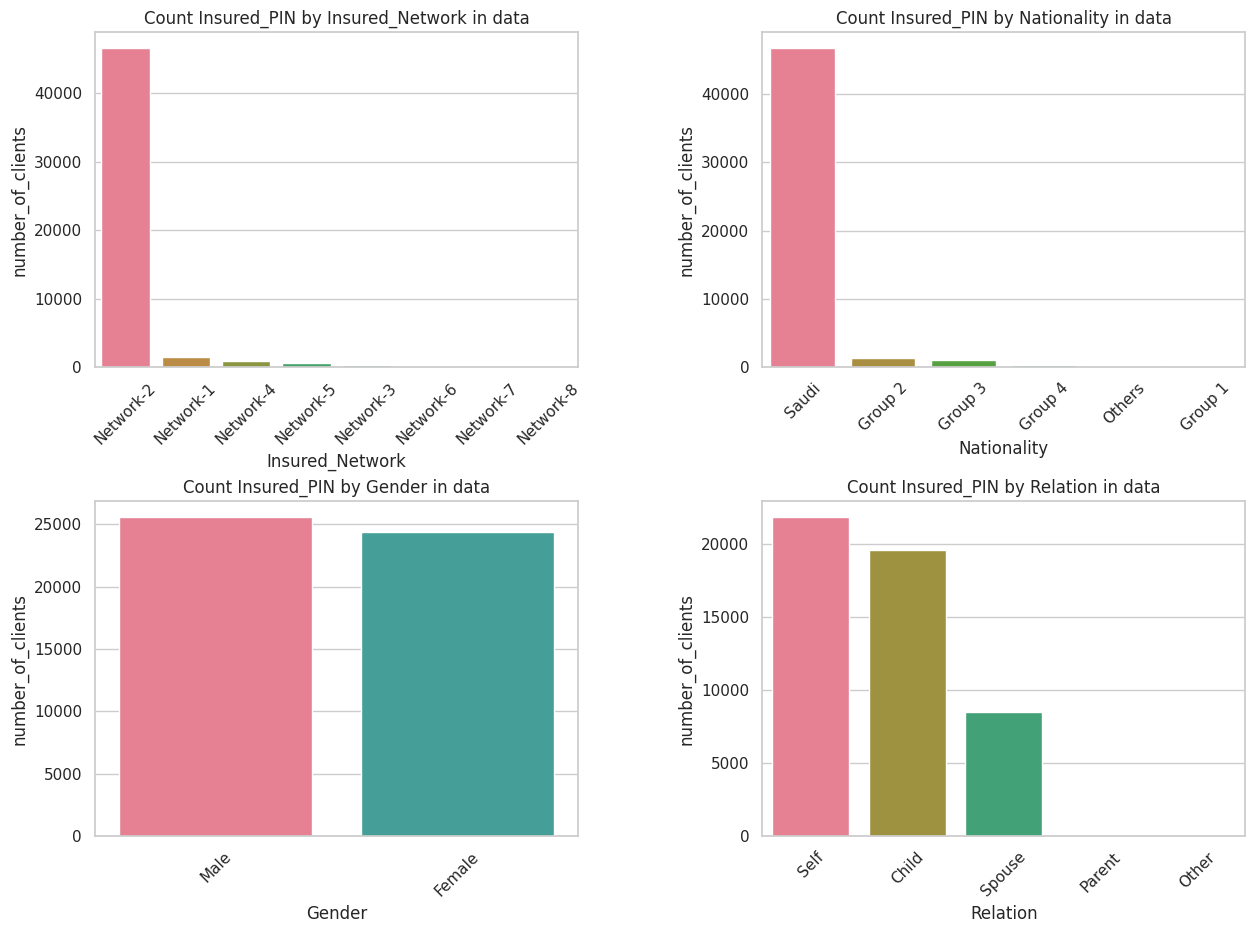

In [42]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.8)
fig.set_size_inches(14, 10, forward=True)

for i, col in enumerate(cat_features):
    agg_df = data.groupby(col).agg({'Insured_PIN': 'count'}).reset_index()
    agg_df = agg_df.sort_values(by='Insured_PIN', ascending=False)
    sns.barplot(x=col,
                y='Insured_PIN',
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Count Insured_PIN by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45)
    axs[i // 2, i % 2].set_ylabel('number_of_clients')
plt.show()

Соотношение классов бинарных числовых признаков

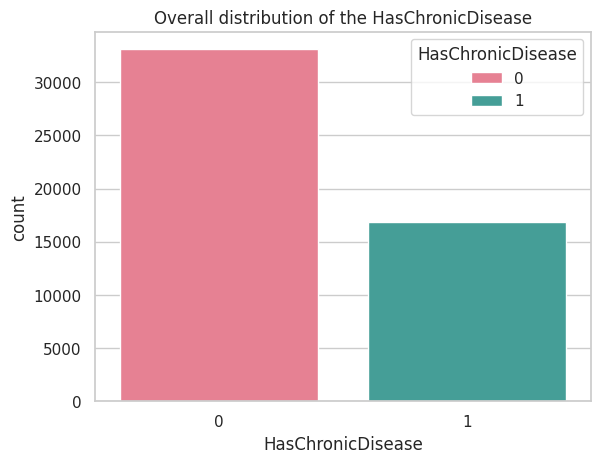

In [43]:
sns.barplot(data=data[binary_num_features[0]].value_counts().reset_index(),
            x=binary_num_features[0],
            y='count',
            hue=binary_num_features[0],
            palette=sns.color_palette("husl", len(data[binary_num_features[0]].value_counts().reset_index())))
plt.title(f"Overall distribution of the {binary_num_features[0]}")
plt.show()

Вывод описательных статистик по небинарным числовым данным

In [8]:
data[num_features+target].describe()

,number_of_services_22,number_of_diagnoses,Exposition_23,number_of_visits_22,client_age_22,client_age_23,Exposition_22,number_of_visits_23
count,50000.000000,50000.000000,50000.000000,50000.000000,49999.000000,49999.000000,50000.000000,50000.000000
mean,22.477420,5.667140,355.588420,5.740320,32.395888,33.395888,358.898960,5.898860
std,29.714146,6.265359,43.779065,6.592556,22.760938,22.760938,35.562003,6.856904
min,0.000000,0.000000,50.000000,0.000000,0.000000,1.000000,50.000000,0.000000
25%,3.000000,1.000000,365.000000,1.000000,11.000000,12.000000,365.000000,1.000000
50%,13.000000,4.000000,365.000000,4.000000,31.000000,32.000000,365.000000,4.000000
75%,31.000000,8.000000,365.000000,8.000000,51.000000,52.000000,365.000000,8.000000
max,962.000000,266.000000,365.000000,151.000000,102.000000,103.000000,365.000000,202.000000


/tmp/ipykernel_28769/3902728846.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels=axs[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_28769/3902728846.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels=axs[1].get_xticklabels(), rotation=45)


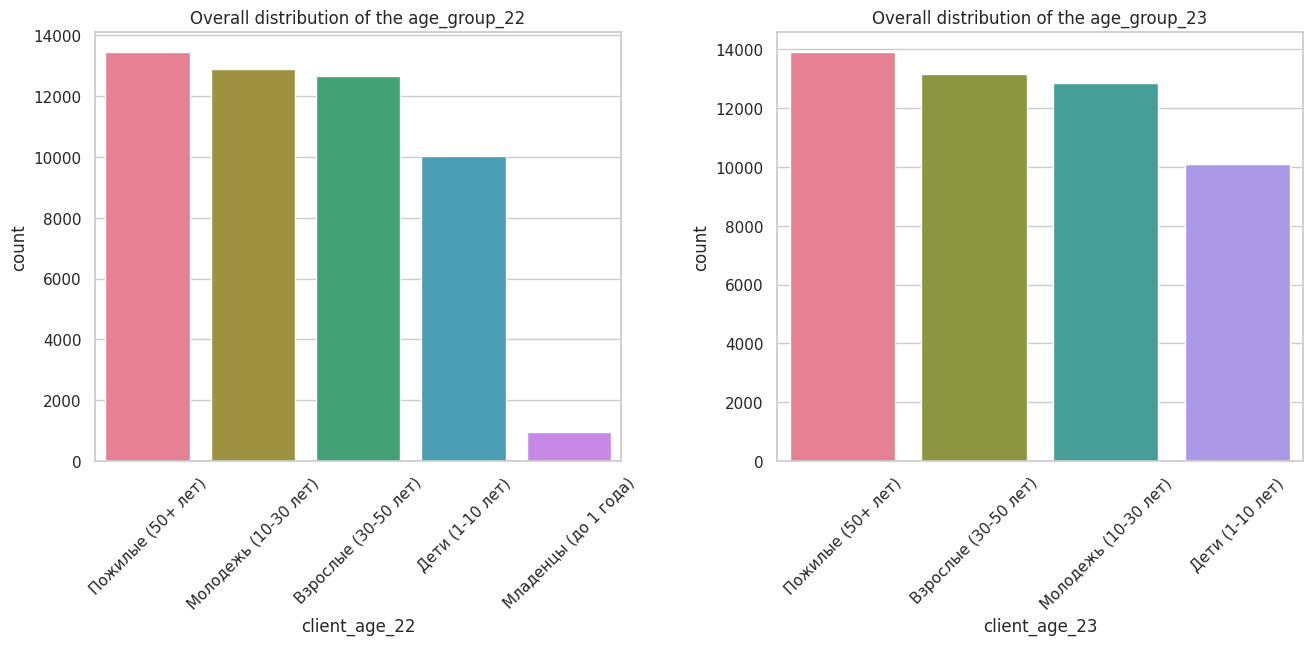

In [11]:
def categorize_age(age):
    if age < 1:
        return 1
    elif age < 10:
        return 2
    elif age < 30:
        return 3
    elif age < 50:
        return 4
    else:
        return 5

age_groups_labels = {
    1: 'Младенцы (до 1 года)',
    2: 'Дети (1-10 лет)',
    3: 'Молодежь (10-30 лет)',
    4: 'Взрослые (30-50 лет)',
    5: 'Пожилые (50+ лет)'
}

fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=1.0)
fig.set_size_inches(14, 5, forward=True)

sns.barplot(data=data['client_age_22'].apply(categorize_age).map(age_groups_labels).value_counts().reset_index(),
            x='client_age_22',
            y='count',
            hue='client_age_22',
            ax=axs[0],
            palette=sns.color_palette("husl", len(data['client_age_22'].apply(categorize_age).value_counts().reset_index())))
axs[0].set_title(f"Overall distribution of the age_group_22")
axs[0].set_xticklabels(labels=axs[0].get_xticklabels(), rotation=45)

sns.barplot(data=data['client_age_23'].apply(categorize_age).map(age_groups_labels).value_counts().reset_index(),
            x='client_age_23',
            y='count',
            hue='client_age_23',
            ax=axs[1],
            palette=sns.color_palette("husl", len(data['client_age_23'].apply(categorize_age).value_counts().reset_index())))
axs[1].set_title(f"Overall distribution of the age_group_23")
axs[1].set_xticklabels(labels=axs[1].get_xticklabels(), rotation=45)

plt.show()

Распределение целевой переменной в различных группах клиентов

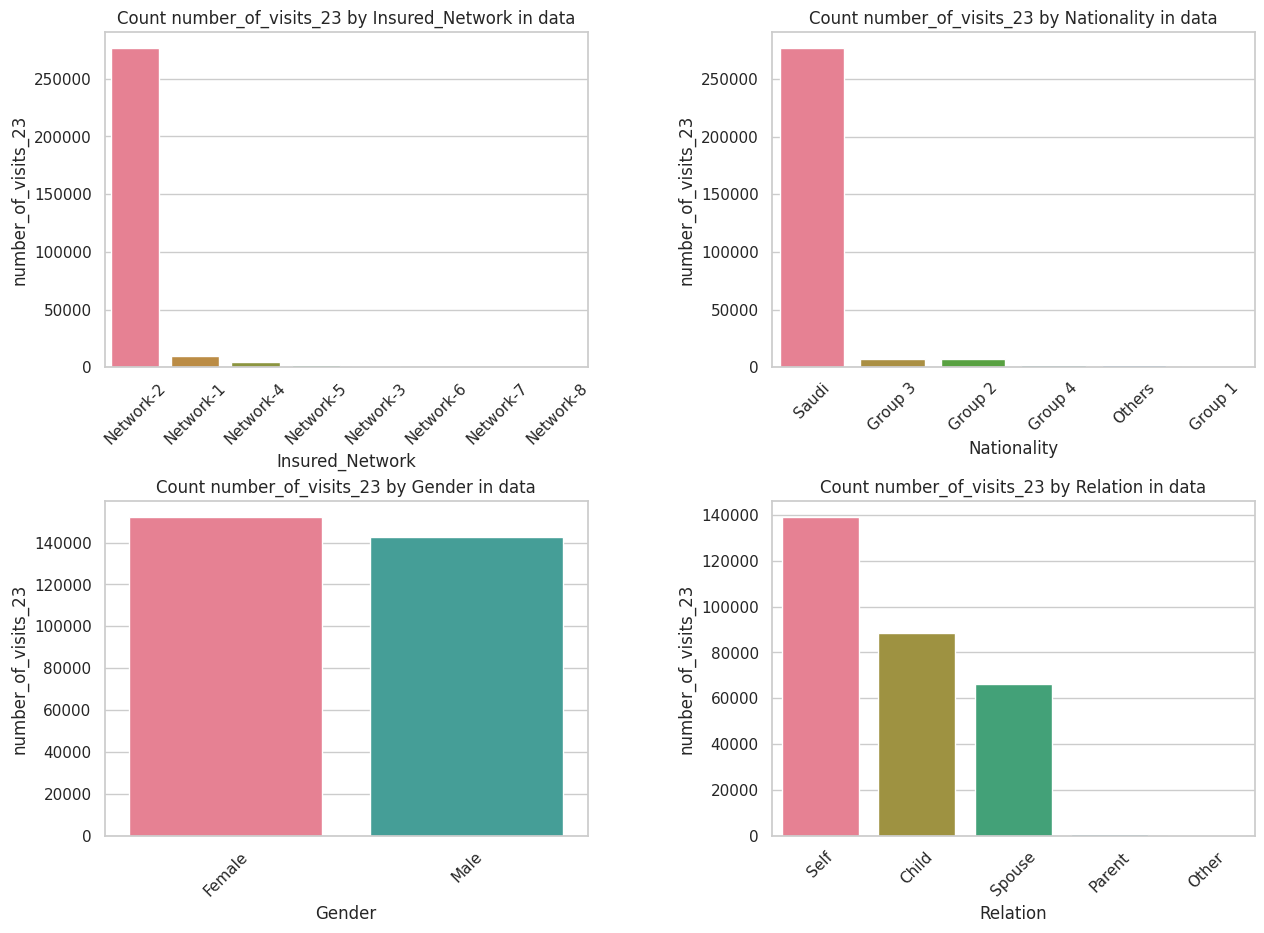

In [30]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.8)
fig.set_size_inches(14, 10, forward=True)

for i, col in enumerate(cat_features):
    agg_df = data.groupby(col).agg({target[0]: 'sum'}).reset_index()
    agg_df = agg_df.sort_values(by=target[0], ascending=False)
    sns.barplot(x=col,
                y=target[0],
                data=agg_df,
                ax=axs[i // 2, i % 2],
                hue=col,
                palette=sns.color_palette("husl", len(agg_df)),
                legend=False)
    axs[i // 2, i % 2].set_title(f'Count number_of_visits_23 by {col} in data')
    axs[i // 2, i % 2].set_xticks(range(len(agg_df)))
    axs[i // 2, i % 2].set_xticklabels(agg_df[col], rotation=45)
    axs[i // 2, i % 2].set_ylabel(target[0])
plt.show()

Выявление скрытых зависимостей между признаками

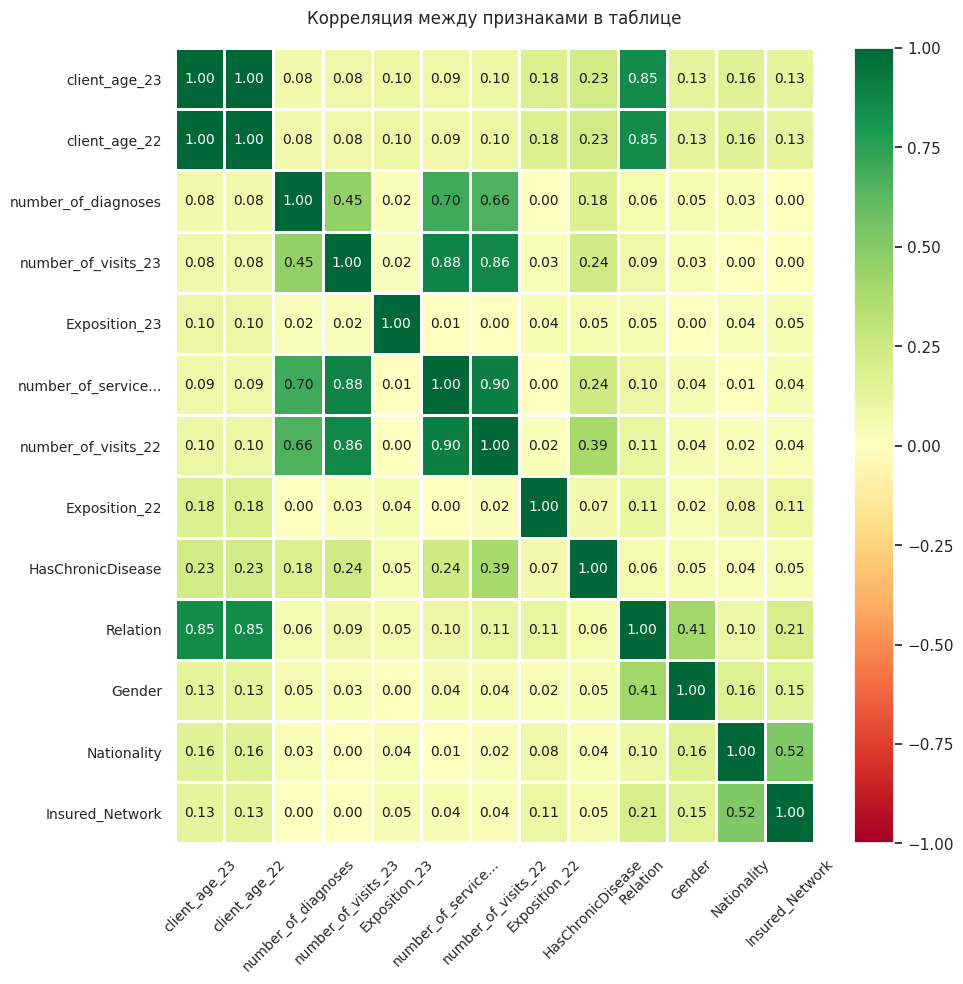

In [31]:
phik_overview = data.drop(columns=['Insured_PIN', 'DoB', 'Diagnoses']).phik_matrix(interval_cols=num_features+target)
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(10, 10))
plt.xticks(rotation=45)
plt.title(f'Корреляция между признаками в таблице', fontsize=12, y=1.02)
plt.tight_layout()

### Выводы и наблюдения
- исследование по клиентам:
  - основная сеть клиник, доступная клиентам - `Network-2`;
  - большинство клиентов, представлены национальностью `Saudi`;
  - мужчин и женщин в выборке примерно одинаковое количество;
  - основные роли клиентов: застрахован лично, застраховал ребёнка, застраховал супруга(у);
- наблюдается большой дисбаланс классов в признаке `HasChronicDisease`;
- исследование числовых признаков:
  - средний возраст клиентов примерно соответствует медианному, пропуск можно заполнить одним из них;
  - можно отследить пять возрастных групп клиентов;
  - среднее количество дней действия полиса по годам примерно соответствует медианному,
    <br>что свидетельствует о близком к нормальному распределению;
  - распределение по возрастным группам практически равномерное, за исключением группы младенцев,
    <br>но их можно отнести к группе "Дети (0-10 лет)";
  - большинство пользователей совершают относительно небольшое количество посещений (до 8),
    <br>но также есть пользователи, которые совершают значительно больше посещений (151 - 202),
    <br>что требует дополнительного изучения,
    <br>похожая ситуация с признаками `number_of_services_22` и	`number_of_diagnoses`;
- исследование по целевому признаку:
  - основная сеть клиник, доступная клиентам - `Network-2`;
  - большинство клиентов, представлены национальностью `Saudi`;
  - женщины посещают клиники больше мужчин;
  - основные роли клиентов по количеству посущений: застрахован лично, застраховал ребёнка, застраховал супруга(у);
- исследование корреляции Фай-Фи в данных:
  - между некоторыми признаками наблюдаются значительные зависимости:
    - relation и client_age;
    - number_of_visits_23, number_of_visits_22, number_of_services_22.

## Генерация дополнительных признаков

Заполнение пропусков

In [12]:
data.fillna({'client_age_23': data['client_age_23'].median(),
             'client_age_22': data['client_age_22'].median()}, inplace=True)
data['client_age_23'] = data['client_age_23'].astype(int)
data['client_age_22'] = data['client_age_22'].astype(int)

Объявление набора данных для обучения базовой модели

In [13]:
data_base = data.copy()

Функции для создания признаков

In [14]:
def categorize_age(age):
    if age < 10:
        return 1
    elif age < 30:
        return 2
    elif age < 50:
        return 3
    else:
        return 4

In [17]:
def feature_engineering(data,
                        num_features,
                        target,
                        test_size,
                        input_columns,
                        output_columns,
                        transformations):
    X_ext_cat = data[num_features].copy()
    for input_col, output_col in zip(input_columns, output_columns):
        X_ext_cat[output_col] = X_ext_cat[input_col].apply(categorize_age)

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1),
                                                        data[target],
                                                        test_size=test_size,
                                                        random_state=RANDOM_STATE)

    afreg = AutoFeatRegressor(feateng_steps=2, max_gb=4, transformations=transformations)
    X_train_afr = afreg.fit_transform(X_train[num_features], y_train)
    X_test_tr = afreg.transform(X_test[num_features])
    X_ext_num = pd.concat([X_train_afr, X_test_tr], ignore_index=True)
    new_num_features = [col for col in X_ext_num.columns if col not in num_features]
    X_ext_num = X_ext_num[new_num_features]
    X_ext_cat = X_ext_cat[output_columns]
    print("Новые категориальные признаки:")
    X_ext_cat.info()
    print("Новые числовые признаки:")
    X_ext_num.info()
    return X_ext_num, X_ext_cat

In [18]:
ext_num_data, ext_cat_data = feature_engineering(data=data,
                                                 num_features=num_features,
                                                 target=target,
                                                 test_size=0.2,
                                                 input_columns=['client_age_22', 'client_age_23'],
                                                 output_columns=['age_group_22', 'age_group_23'],
                                                 transformations=["log", "exp-", "sqrt"])

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


Новые категориальные признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   age_group_22  50000 non-null  int64
 1   age_group_23  50000 non-null  int64
dtypes: int64(2)
memory usage: 781.4 KB
Новые числовые признаки:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Exposition_22*exp(-client_age_22)              50000 non-null  float64
 1   number_of_diagnoses*number_of_visits_22        50000 non-null  float64
 2   number_of_services_22*number_of_visits_22      50000 non-null  float64
 3   number_of_visits_22*exp(-number_of_visits_22)  50000 non-null  float64
 4   sqrt(client_age_23)*sqrt(number_of_visits_22)  50000 non-null  

In [19]:
full_df = data.merge(ext_num_data, left_index=True, right_index=True).merge(ext_cat_data, left_index=True, right_index=True)

In [24]:
ext_num_features = ext_num_data.columns.to_list()
ext_cat_features = ext_cat_data.columns.to_list()

### Выводы и наблюдения
- заполнены пропуски;
- создан базовый датафрейм;
- добавлены категориальные признаки - возрастная группа;
- при помощи библиотеки `autofeat` добавлены числовые признаки

## Отбор финального набора обучающих признаков

### baseline

In [38]:
data_base = data_base[cat_features+binary_num_features+ num_features+target]

### main_dataset

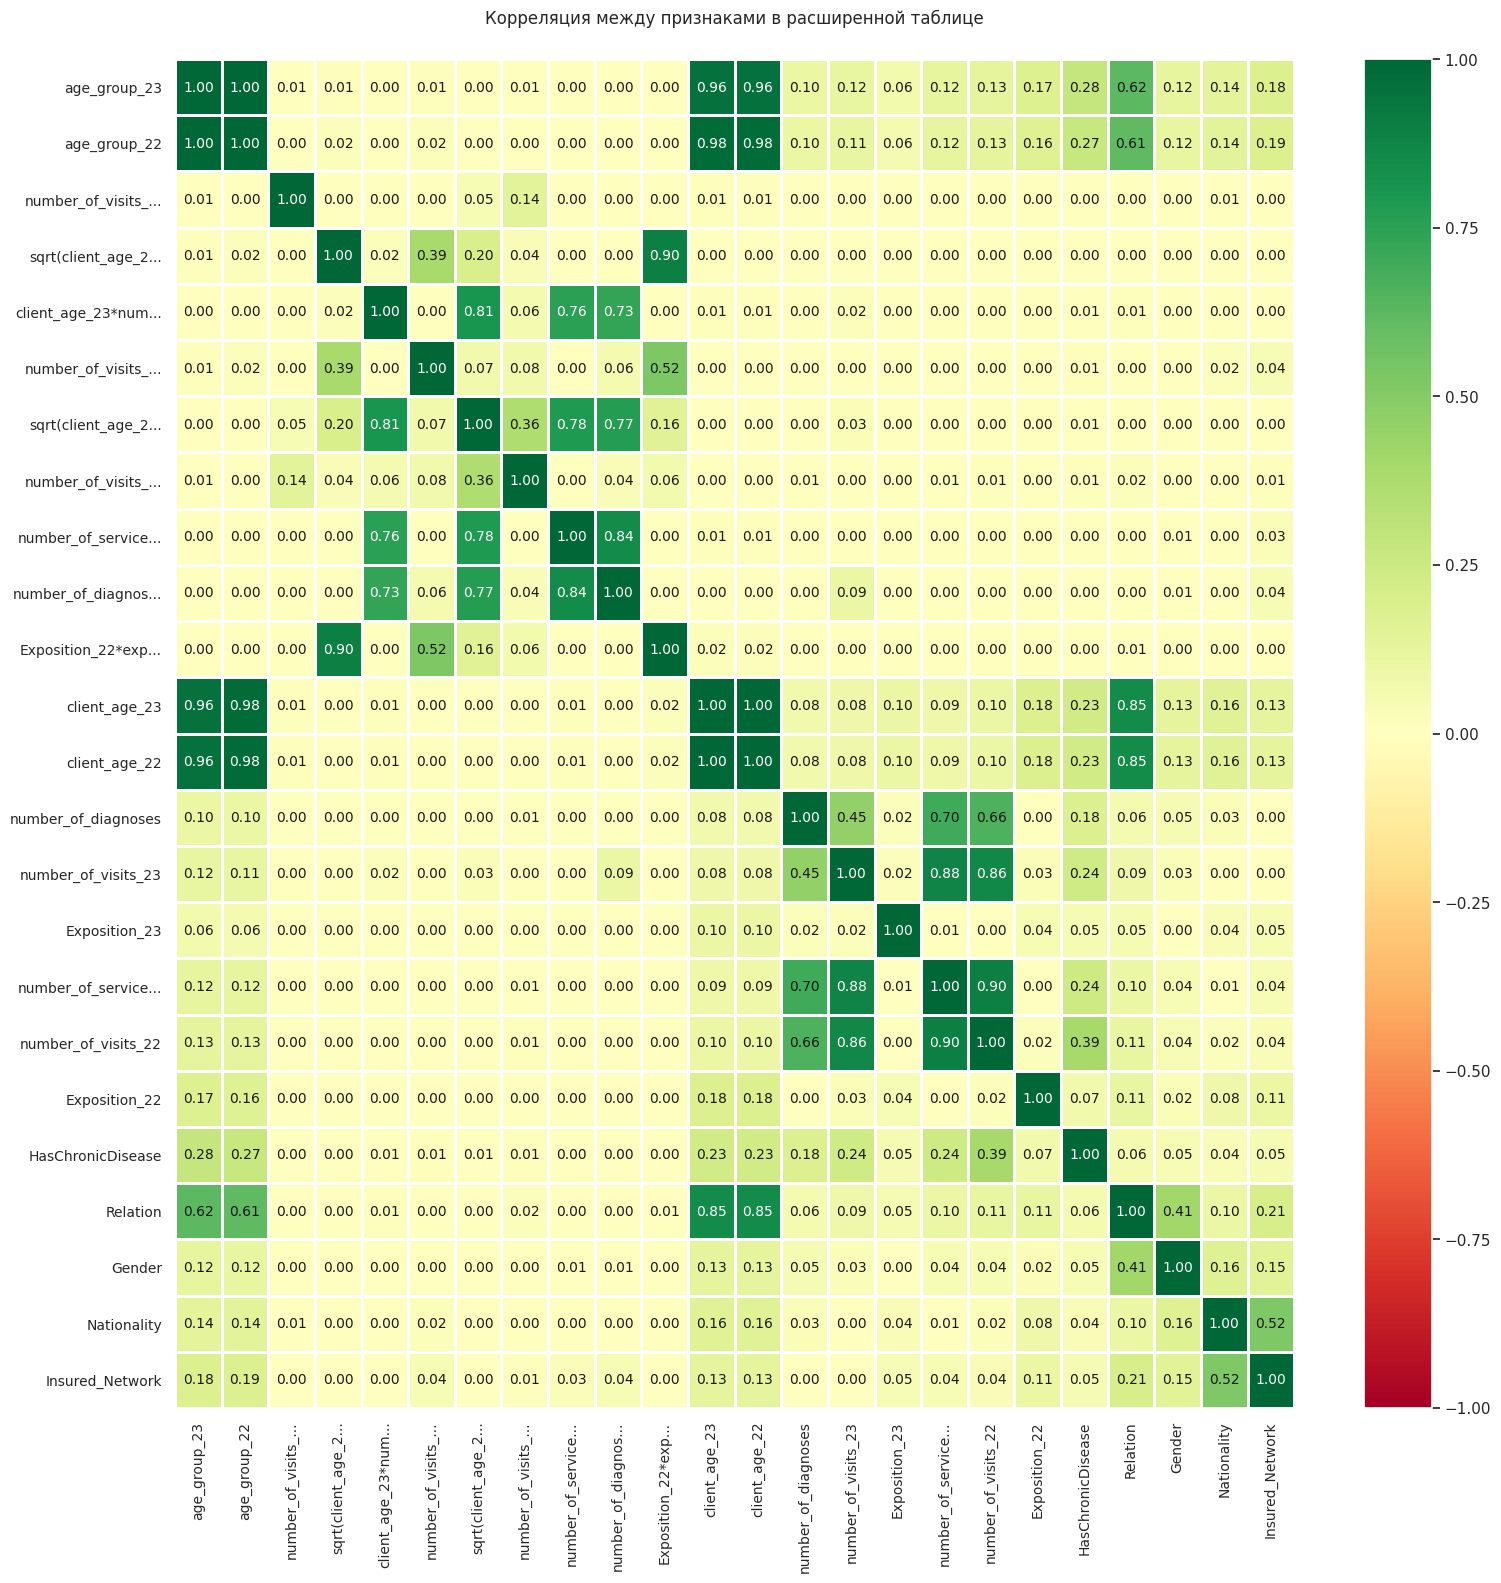

In [23]:
phik_overview = full_df.drop(columns=['Insured_PIN', 'DoB', 'Diagnoses']).phik_matrix(interval_cols=num_features+target+ext_num_data.columns.to_list())
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(16, 16))
plt.xticks(rotation=90)
plt.title(f'Корреляция между признаками в расширенной таблице', fontsize=12, y=1.02)
plt.tight_layout()

Удаление признаков

In [28]:
num_features.remove('number_of_services_22')  # коррелирует с целевым признаком
num_features.remove('number_of_visits_22')  # коррелирует с целевым признаком
num_features.remove('client_age_23')  # коррелирует с признаком возрастной группы
num_features.remove('client_age_22')  # коррелирует с признаком возрастной группы
ext_cat_features.remove('age_group_23')  # коррелирует с признаком возрастной группы

### Выводы и наблюдения
- отобран финальный набор обучающих признаков

## Поготовка данных для обучения

In [36]:
# cat_features
# binary_num_features
# num_features
# target
# ext_cat_features
# ext_num_features

In [44]:
def data_preparing(data, test_size, target, cat_features, num_features, remain_features):
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1),
                                                        data[target],
                                                        test_size=test_size,
                                                        random_state=RANDOM_STATE)
    scaler = StandardScaler()
    encoder = OneHotEncoder(dtype=np.int8)
    X_train_scl = pd.DataFrame(scaler.fit_transform(X_train[num_features]), columns=num_features, index=X_train.index)
    X_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_features]).toarray(), columns=encoder.get_feature_names_out(cat_features), index=X_train.index)
    X_train_enc = X_train[remain_features].merge(X_train_scl, left_index=True, right_index=True).merge(X_train_ohe, left_index=True, right_index=True)
    X_test_scl = pd.DataFrame(scaler.transform(X_test[num_features]), columns=num_features, index=X_test.index)
    X_test_ohe = pd.DataFrame(encoder.transform(X_test[cat_features]).toarray(), columns=encoder.get_feature_names_out(cat_features), index=X_test.index)
    X_test_enc = X_test[remain_features].merge(X_test_scl, left_index=True, right_index=True).merge(X_test_ohe, left_index=True, right_index=True)
    print('Размерности полученных выборок:')
    print(X_train_enc.shape, X_test_enc.shape, y_train.shape, y_test.shape)
    return X_train_enc, X_test_enc, y_train, y_test

### baseline

In [42]:
X_train_base, X_test_base, y_train, y_test = data_preparing(data=data_base,
                                                            test_size=0.2,
                                                            target=target,
                                                            cat_features=cat_features,
                                                            num_features=num_features,
                                                            remain_features=binary_num_features)

Размерности полученных выборок:
(40000, 25) (10000, 25) (40000, 1) (10000, 1)


### main_dataset

In [47]:
X_train_main, X_test_main, y_train, y_test = data_preparing(data=full_df,
                                                            test_size=0.2,
                                                            target=target,
                                                            cat_features=cat_features+ext_cat_features,
                                                            num_features=num_features+ext_num_features,
                                                            remain_features=binary_num_features)

Размерности полученных выборок:
(40000, 38) (10000, 38) (40000, 1) (10000, 1)


### Выводы и наблюдения
- данные разделены на обучающую и тестовую выборки;
- произведено кодирование категориальных признаков;
- числовые признаки масштабированы

## Обучение моделей

In [50]:
def model_fitting(model_name=None, features_train=None, target_train=None, params=None, cv=4):
    if model_name == 'Baseline':
        model = LinearRegression(**params)
        model.fit(features_train, target_train)
        cv_strategy = StratifiedKFold(n_splits=cv)
        cv_res = cross_validate(model, features_train, target_train, cv=cv_strategy, n_jobs=-1, scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'])
        for key, value in cv_res.items():
            cv_res[key] = round(-value.mean(), 3)
        print(f"Результаты кросс-валидации: {cv_res}")
    else:
        if model_name == 'Linear Regression':
            model = LinearRegression()
        elif model_name == 'Random Forest Regressor':
            model = RandomForestRegressor()
            
        grid_search = GridSearchCV(model,
                                   params,
                                   cv=cv,
                                   n_jobs=-1,
                                   scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
                                   refit='neg_mean_squared_error')
        grid_search.fit(features_train, target_train)
        cv_res = {'test_neg_mean_squared_error': round(-grid_search.cv_results_['mean_test_neg_mean_squared_error'].mean(), 3),
                  'test_r2': round(grid_search.cv_results_['mean_test_r2'].mean(), 3),
                  'test_neg_mean_absolute_error': round(-grid_search.cv_results_['mean_test_neg_mean_absolute_error'].mean(), 2)}
        print("Лучший результат:", cv_res)
        print("Лучшие гиперпараметры:", grid_search.best_params_)
        model = grid_search.best_estimator_
        model.fit(features_train, target_train)
    
    y_pred = model.predict(features_train)
    mse_value = mean_squared_error(target_train, y_pred)
    mae_value = mean_absolute_error(target_train, y_pred)
    r2_value = r2_score(target_train, y_pred)

    return cv_res['test_neg_mean_squared_error'], cv_res['test_r2'], cv_res['test_neg_mean_absolute_error'], model

### baseline

In [71]:
params_base = {'fit_intercept':True,
               'copy_X':True,
               'n_jobs':-1,
               'positive':False}
mse_base, r2_base, mae_base, baseline = model_fitting(model_name='Baseline',
                                                      features_train=X_train_base,
                                                      target_train=y_train,
                                                      params=params_base,
                                                      cv=4)

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Результаты кросс-валидации: {'fit_time': -0.037, 'score_time': -0.007, 'test_neg_mean_squared_error': 28.441, 'test_r2': -0.403, 'test_neg_mean_absolute_error': 3.452}


### linear regression

In [51]:
params_lr = {'fit_intercept':[True, False],
             'copy_X':[True, False],
             'n_jobs':[-1, 4],
             'positive':[True,False]}
mse_lr, r2_lr, mae_lr, model_lr = model_fitting(model_name='Linear Regression',
                                                features_train=X_train_main,
                                                target_train=y_train,
                                                params=params_lr,
                                                cv=2)

Лучший результат: {'test_neg_mean_squared_error': 28.661, 'test_r2': 0.398, 'test_neg_mean_absolute_error': 3.47}
Лучшие гиперпараметры: {'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}


### random forest

In [65]:
params_rf = {'n_estimators':[100, 150],
             'criterion':['squared_error', 'absolute_error'],
             'max_depth':[1, 10],
             'bootstrap': [True],
             'n_jobs':[4]}
mse_rf, r2_rf, mae_rf, model_rf = model_fitting(model_name='Random Forest Regressor',
                                                features_train=X_train_main,
                                                target_train=y_train.values.ravel(),
                                                params=params_rf,
                                                cv=2)

Лучший результат: {'test_neg_mean_squared_error': 33.303, 'test_r2': 0.3, 'test_neg_mean_absolute_error': 3.62}
Лучшие гиперпараметры: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': 4}


Логирование модели с её артефактами

In [66]:
# !pip freeze > requirements.txt
pip_requirements = "requirements.txt"
signature = mlflow.models.infer_signature(X_train_main.values, y_train.values)
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-04-05",
    "metrics": {'mse':33.303, 'r2':0.3, 'mae':3.62},
    "hyperparameters": {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': 4},
    "data_used": "data_main",
    "library_versions": {"mlflow": "2.11.3", "scikit-learn": "1.4.1"}
}
input_example = (X_train_main).iloc[0].to_dict()
code_paths = ["visits_number_predict.ipynb"]
best_params = {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 10, 'n_estimators': 150, 'n_jobs': 4}
cv_res = {'test_neg_mean_squared_error': 33.303, 'test_r2': 0.3, 'test_neg_mean_absolute_error': 3.62}

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME[2], experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(best_params)
    mlflow.log_metrics(cv_res)
    model_info = mlflow.sklearn.log_model(
        sk_model=model_rf,
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        registered_model_name=REGISTRY_MODEL_NAME[2],
        await_registration_for=60
		)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)
assert run.info.status == "FINISHED"

/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/denis/Documents/main_venv/test_mains_lab/.env_lab/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'random_forest'.
2024/04/05 19:05:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: random_forest, version 1
Created version '1' of model '

### Выводы и наблюдения
Обучены и оценены модели:
- `linear regression` на базовых признаках без подбора гиперпараметров - в качестве baseline;
- `linear regression` на базовых признаках с подбором гиперпараметров `GridSearch`;
- `linear regression` на расширенных признаках с подбором гиперпараметров `GridSearch`;
- `Random Forest Regressor` на расширенных признаках с подбором гиперпараметров `GridSearch`

## Выбор лучшей модели

In [67]:
connection.update(postgres_credentials)
with psycopg2.connect(**connection) as conn:
    with conn.cursor() as cur:
        # cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        # table_data = []
        # for table_name in cur.fetchall():
        #     cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
        #     table_data.append((table_name[0], cur.fetchone()[0]))
        # print('Находящиеся в базе таблицы:')
        # display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT
                         model_versions.name AS model_name,
                         model_versions.version,
                         STRING_AGG(metrics.key || '=' || metrics.value, '; ') AS metrics,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time')
                       GROUP BY model_versions.name, model_versions.version, metrics.run_uuid
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Модели и их метрики:


,model_name,version,metrics,run_uuid
0,baseline,1,test_neg_mean_squared_error=24.526; test_r2=-0...,c005c770265d4c17bf8b99a5e740eddb
1,linear_regression,2,test_neg_mean_squared_error=28.661; test_r2=0....,e16ff10961c6433aa43c6807a76ee72a
2,linear_regression,1,test_neg_mean_squared_error=24.792; test_r2=0....,5f57e6571f8b42d5ba56023c612ec3f8
3,random_forest,1,test_neg_mean_squared_error=33.303; test_r2=0....,32de4d13ac5a4712ac5783c183575fcf


### Выводы и наблюдения
- наилучший результат по выбранной метрике показала модель:
|model|params|metric|
|---|---|---|
|linear_regression|fit_intercept=True; copy_X=True; n_jobs=-1; positive=False|mse=24.526|

## Оценка качества предсказания модели

In [73]:
y_pred = baseline.predict(X_test_base)
mse_test = mean_squared_error(y_test, y_pred)
print(f"MSE лучшей модели на отложенной выборке: {mse_test}")

MSE лучшей модели на отложенной выборке: 25.80588476867676


## Анализ важности признаков

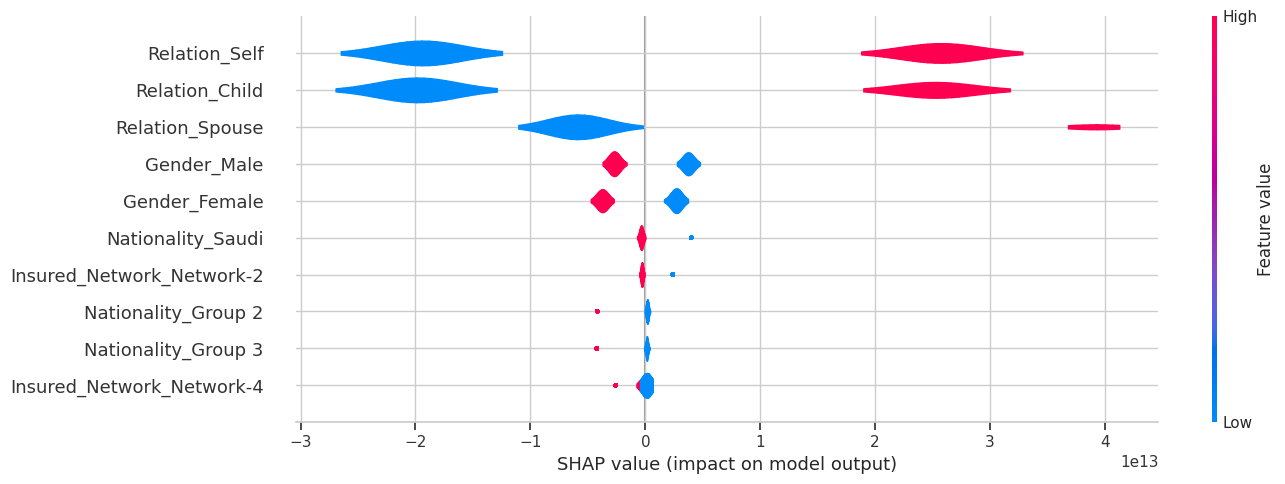

In [90]:
explainer = shap.Explainer(baseline, X_train_base)
shap_values = explainer(X_test_base)
shap.summary_plot(shap_values=shap_values,
                  features=np.array(X_test_base),
                  feature_names=X_test_base.columns.to_list(),
                  max_display=10,
                  plot_type='violin',
                  plot_size=(14, 5))

### Выводы и наблюдения
- наиболее важными признаками определены `Relation`, `Gender`, `Nationality`

## Прогноз для отложенных данных

In [91]:
X_train_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 39087 to 15795
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HasChronicDisease          40000 non-null  int64  
 1   Exposition_22              40000 non-null  float64
 2   number_of_diagnoses        40000 non-null  float64
 3   Exposition_23              40000 non-null  float64
 4   Insured_Network_Network-1  40000 non-null  int8   
 5   Insured_Network_Network-2  40000 non-null  int8   
 6   Insured_Network_Network-3  40000 non-null  int8   
 7   Insured_Network_Network-4  40000 non-null  int8   
 8   Insured_Network_Network-5  40000 non-null  int8   
 9   Insured_Network_Network-6  40000 non-null  int8   
 10  Insured_Network_Network-7  40000 non-null  int8   
 11  Insured_Network_Network-8  40000 non-null  int8   
 12  Nationality_Group 1        40000 non-null  int8   
 13  Nationality_Group 2        40000 non-null  int8

In [94]:
data_review(holdout_data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Insured_PIN            10000 non-null  int64         
 1   Insured_Network        10000 non-null  object        
 2   Nationality            10000 non-null  object        
 3   Gender                 10000 non-null  object        
 4   Relation               10000 non-null  object        
 5   DoB                    10000 non-null  datetime64[ns]
 6   Diagnoses              8274 non-null   object        
 7   HasChronicDisease      10000 non-null  int64         
 8   Exposition_22          10000 non-null  int64         
 9   number_of_visits_22    10000 non-null  int64         
 10  number_of_services_22  10000 non-null  int64         
 11  Exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64

,Insured_PIN,Insured_Network,Nationality,Gender,Relation,DoB,Diagnoses,HasChronicDisease,Exposition_22,number_of_visits_22,number_of_services_22,Exposition_23
0,1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
1,22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365
2,1518945,Network-2,Saudi,Female,Spouse,1962-11-28,D64.9;J06;H04.1;M13.9,0,365,5,11,365
3,1344077,Network-2,Saudi,Male,Child,2003-07-09,J06.9;J06.8;J02;G44.0;M25.5;R51;E55;L03,1,365,9,30,365
4,1354276,Network-2,Saudi,Female,Spouse,1995-07-22,UNKRC;N64;A09,0,365,3,10,365



количество полных дубликатов строк: 0

Вывод количества уникальных записей в каждом текстовом признаке:
Количество уникальных записей в признаке 'Insured_Network': 8
Количество уникальных записей в признаке 'Nationality': 6
Количество уникальных записей в признаке 'Gender': 2
Количество уникальных записей в признаке 'Relation': 5
Количество уникальных записей в признаке 'Diagnoses': 7434

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'Insured_PIN': 10000
Количество уникальных записей в признаке 'HasChronicDisease': 2
Количество уникальных записей в признаке 'Exposition_22': 189
Количество уникальных записей в признаке 'number_of_visits_22': 64
Количество уникальных записей в признаке 'number_of_services_22': 212
Количество уникальных записей в признаке 'Exposition_23': 154

Самая ранняя дата в признаке 'DoB': 1922-02-13 00:00:00
Самая поздняя дата в признаке 'DoB': 2022-11-12 00:00:00


## Отчёт по исследованию

**Загрузка данных и ознакомление с ними**

Выполнено
- данные загружены и изучены;
- в них выявлены пропуски, типы данных;
- намечен ход дальнейшей обработки

**Первичная обработка данных**

Выполнено
- добавлен признак, в котором посчитано количество диагнозов у клиента;
- добавлены признаки с возрастом клиента на конец 2022 и 2023 годов

**Исследовательский анализ данных**

Выполнено
- изучено поведение клиентов;
- изучены численные и категориальные признаки;
- проверены связи признаков с целевой переменной;
- исследованы корреляции между признаками

**Создание новых признаков (при необходимости)**

Выполнено
- добавлены категориальные признаки - возрастная группа;
- при помощи библиотеки autofeat добавлены числовые признаки

**Отбор финального набора обучающих признаков**

Выполнено
- произведён отбор финального набора признаков

**Подготовка данных для обучения**

Выполнено
- данные разделены на обучающую и тестовую выборки;
- произведено кодирование категориальных признаков;
- числовые признаки масштабированы

**Выбор и обучение моделей**

Выполнено
<br>Обучены и оценены модели:
- `linear regression` на базовых признаках без подбора гиперпараметров - в качестве baseline;
- `linear regression` на базовых признаках с подбором гиперпараметров `GridSearch`;
- `linear regression` на расширенных признаках с подбором гиперпараметров `GridSearch`;
- `Random Forest Regressor` на расширенных признаках с подбором гиперпараметров `GridSearch`

**Оценка качества предсказания лучшей модели на тестовой выборке**

**Анализ важности признаков лучшей модели**

**Прогноз для отложенных данных**

